Now using [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) tutorial

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


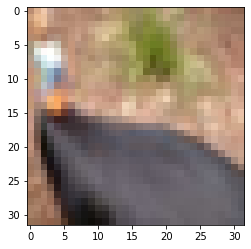

bird


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + .5
    npimg: np.array = img.numpy()
    # flipping x and y
    plt.imshow(npimg.transpose((1, 2, 0)))
    plt.show()

images, labels = iter(trainloader).next()
imshow(images[0])
print(classes[labels[0].item()])

In [6]:
# just playing with transpose
np.array([[1,2,3], [3, 4, 5], [6,7,8]]).transpose(1, 0)


array([[1, 3, 6],
       [2, 4, 7],
       [3, 5, 8]])

Let's make a nn for that

the best tutorial to convolutions, ever: [mow](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# it is copypasted from previous thing. 

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # input is 3 * 32 * 32
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel

        # this takes 3 colors over 5x5 sectors with default stride of 1, 
        # (3*5^2 inputs per square) and squishes each square down to 6 outputs.
        # and that means you get 6*(32-5+1)^2 = 6*28*28 outputs, I guess?
        self.conv1 = nn.Conv2d(3, 6, 5) 

        #===== there's a pool in here, which squishes each nx2x2 to nx1x1, thus making it 6*14*14 

        # now we squish each 6*5*5 sector from 6*14*14 squished thingey,
        # and squish them further, to 16 per square, and it looks like it should turn into 16*(14-5+1)^2 -> 16*10*10
        self.conv2 = nn.Conv2d(6, 16, 5)

        #===== there's another pool in here, which squishes each nx2x2 to nx1x1, thus making it 16*5*5 

        self.fc1 = nn.Linear(16 * 5 * 5, 120) # And they are fed to 120 outputs
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        # and relu is a thing that removes a lot noise, one of those pesky activation functions I guess
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # view here is basically reshaping tensor to be one-dimensional
        x = x.view(-1, 16 * 5 * 5)
        # reeeelu everywheaaaa. not sure, why, gotta try disabling it
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net.conv2.out_channels)
print(net)

16
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [108]:
# now let's train this bad girl

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), .01, .09)
criterion = nn.CrossEntropyLoss()


In [104]:
i = 0
running_loss = 0
# epochs are repetitions of dataset, lol
for epoch in range(2):
    for example, labels in trainloader:
        i+=1
        net.zero_grad()
        output = net(example)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 0:
            print(f"{epoch} || {running_loss / 2000:.4}")
            running_loss = 0

0 || 2.147
0 || 1.791
0 || 1.613
0 || 1.529
0 || 1.484
0 || 1.458
1 || 1.39
1 || 1.359
1 || 1.328
1 || 1.31
1 || 1.295
1 || 1.283


Yay we trained something! Now let's try its accuracy.

In [92]:
hits, total = 0.0, 0
for inp, labels in testloader:
    output = net(inp)
    _, pred = torch.max(output.data, 1)
    that_hits = (labels == pred).sum().item()
    hits += that_hits
    total += len(labels)

print(f"Accuracy: {hits / total * 100 :.3}%")
    

Accuracy: 56.3%


In [94]:
# HOLY SHIT THIS IS SOME HOT SYNTAX
(torch.Tensor(10) == torch.Tensor(10)).sum().item()

6

Also we can save our puny network!

In [95]:
torch.save(net, "mow.pt") # and it weights in at 1/4 of a megabyyyte! huuuge!